## 60/40 Portfolio Analysis


In [81]:
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

import riskfolio as rp
from backend.utils import pickle_it, jformat

pd.options.mode.chained_assignment = None  # default='warn' - disable some pandas warnings
pd.options.display.float_format = '{:,.2f}'.format


### Chart Template

In [82]:
%%capture
# MatPlotLib settings
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler

# Swan Colors
swan_colors = ['#31597F', '#7B96B0', '#C3D9E9', '#DAE1E8']
mpl.rcParams['lines.color'] = '#31597F'
mpl.rcParams['text.color'] = '#31597F'
mpl.rcParams['axes.prop_cycle'] = cycler(color=swan_colors)
mpl.rcParams['lines.linewidth'] = 1
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rcParams["figure.figsize"] = (10,5)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=10)   
plt.rc('xtick', labelsize=10, color='#00305E')  
plt.rc('ytick', labelsize=10, color='#00305E')    
plt.rc('legend', fontsize=12)
plt.rc('font', size=8)          

import matplotlib.ticker as ticker

# Define the formatter
formatter = ticker.StrMethodFormatter('{x:,.0f}')

from PIL import Image
fig, ax = plt.subplots()
img = Image.open('swan.jpg')
width, height = ax.figure.get_size_inches()*fig.dpi
wm_width = int(width / 2) 
scaling = (wm_width / float(img.size[0]))
wm_height = int(float(img.size[1])*float(scaling))
img = img.resize((wm_width, wm_height), Image.ANTIALIAS)

def add_watermark(ax, img):
    ax.imshow(img, aspect='equal', zorder=1, alpha=0.2, extent=(0.3, 1.6, 0.05, 0.3), transform=ax.transAxes)
    


### Define the function to download adjusted historical data.

In [132]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4}'.format

# Date range
start = '2016-01-01'
end = '2023-03-30'

# Tickers of assets
tickers = ['BND', 'VTI', 'BTC-USD']
weights = [0.4, 0.6, 0.0]
weight = {'BND': 0.4, 
          'VTI': 0.6, 
          'BTC-USD': 0
          }
tickers.sort()

# Downloading data
df = yf.download(tickers, start = start, end = end)
df = df.loc[:,('Adj Close', slice(None))]
df.columns = [ticker + '_price' for ticker in tickers]

for ticker in tickers:
        df[ticker + '_price'].fillna(method='backfill', inplace=True)
        df[ticker + '_price'].fillna(method='ffill', inplace=True)
        # Include weights
        df[ticker + '_initial_weight'] = weight[ticker]
        # include percentage change
        df[ticker + '_day_return'] = df[ticker +
                                                '_price'].pct_change()
        df[ticker + '_day_return'].fillna(0, inplace=True)
        # include factor of return
        df[ticker +
                '_perc_factor'] = (df[ticker + '_day_return']) + 1
        df[ticker + '_perc_factor'].fillna(1, inplace=True)



[*********************100%***********************]  3 of 3 completed


KeyError: "None of [Index(['BND_returns', 'BTC-USD_returns', 'VTI_returns'], dtype='object')] are in the [columns]"

In [130]:
df

,BND_price,BTC-USD_price,VTI_price,BND_initial_weight,BND_day_return,BND_perc_factor,BTC-USD_initial_weight,BTC-USD_day_return,BTC-USD_perc_factor,VTI_initial_weight,VTI_day_return,VTI_perc_factor
Date,,,,,,,,,,,,
2016-01-01,66.98,434.3,90.45,0.4,0.0,1.0,0,0.0,1.0,0.6,0.0,1.0
2016-01-02,66.98,433.4,90.45,0.4,0.0,1.0,0,-0.002063,0.9979,0.6,0.0,1.0
2016-01-03,66.98,430.0,90.45,0.4,0.0,1.0,0,-0.007907,0.9921,0.6,0.0,1.0
2016-01-04,66.98,433.1,90.45,0.4,0.0,1.0,0,0.007163,1.007,0.6,0.0,1.0
2016-01-05,67.06,432.0,90.66,0.4,0.001239,1.001,0,-0.002611,0.9974,0.6,0.002239,1.002
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-25,73.4,2.749e+04,197.4,0.4,-0.01038,0.9896,0,5.172e-05,1.0,0.6,0.002539,1.003
2023-03-26,73.4,2.799e+04,197.4,0.4,0.0,1.0,0,0.01817,1.018,0.6,0.0,1.0
2023-03-27,73.4,2.714e+04,197.4,0.4,0.0,1.0,0,-0.03052,0.9695,0.6,0.0,1.0


### Define the function to calculate returns and rebalance the portfolio.

In [108]:
def calculate_returns_and_rebalance(tickers, weights, start_date, end_date, rebalancing_frequency, bitcoin_allocation, bitcoin_rebalancing_frequency):
    tickers.append('BTC-USD')
    weights.append(bitcoin_allocation)
    
    dfs = []
    for ticker in tickers:
        df = download_adjusted_data(ticker, start_date, end_date)
        df[ticker + '_returns'] = df['Adjusted Close'].pct_change()
        dfs.append(df)
    
    combined_df = pd.concat([df[['Adjusted Close', ticker + '_returns']] for df, ticker in zip(dfs, tickers)], axis=1)
    combined_df['Portfolio_returns'] = combined_df[[ticker + '_returns' for ticker in tickers]].mul(weights, axis=1).sum(axis=1)
    
    if rebalancing_frequency != 'never':
        rebalance_dates = pd.date_range(start=start_date, end=end_date, freq=rebalancing_frequency.upper())
        for rebalance_date in rebalance_dates:
            if rebalance_date in combined_df.index:
                combined_df.loc[rebalance_date, 'Portfolio_returns'] = np.nan
                combined_df[[ticker + '_returns' for ticker in tickers[:-1]]] = combined_df[[ticker + '_returns' for ticker in tickers[:-1]]].mul(weights[:-1], axis=1)
    
    if bitcoin_rebalancing_frequency != 'never':
        bitcoin_rebalance_dates = pd.date_range(start=start_date, end=end_date, freq=bitcoin_rebalancing_frequency.upper())
        for rebalance_date in bitcoin_rebalance_dates:
            if rebalance_date in combined_df.index:
                combined_df.loc[rebalance_date, 'BTC-USD_returns'] = np.nan
                
    return combined_df


### Create input widgets for start and end dates, rebalancing frequency, Bitcoin allocation, and Bitcoin rebalancing frequency.

In [85]:
start_date_input = widgets.DatePicker(description='Start Date')
end_date_input = widgets.DatePicker(description='End Date')
rebalancing_frequency_input = widgets.Dropdown(
    options=['M', 'Q', 'Y', 'never'],
    value='Y',
    description='Rebalancing:',
)
bitcoin_allocation_input = widgets.FloatSlider(
    value=0,
    min=0,
    max=1,
    step=0.01,
    description='Bitcoin Allocation:',
    readout_format='.2%',
)
bitcoin_rebalancing_frequency_input = widgets.Dropdown(
    options=['M', 'Q', 'Y', 'never'],
    value='Y',
    description='Bitcoin Rebalancing:',
)


### Define the function to update the chart based on user inputs.

In [86]:

def update_chart(start_date, end_date, rebalancing_frequency, bitcoin_allocation, bitcoin_rebalancing_frequency):
    tickers = ['BND', 'VTI']
    weights = [0.4, 0.6]
    
    combined_df = calculate_returns_and_rebalance(tickers, weights, start_date, end_date, rebalancing_frequency, bitcoin_allocation, bitcoin_rebalancing_frequency)
    combined_df[[ticker + '_returns' for ticker in tickers] + ['Portfolio_returns']] = (combined_df[[ticker + '_returns' for ticker in tickers] + ['Portfolio_returns']] + 1).cumprod() * 100
    
    # Plot asset returns and portfolio returns
    plt.figure(figsize=(12, 6))
    for ticker in tickers:
        plt.plot(combined_df.index, combined_df[ticker + '_returns'], label=ticker)
    plt.plot(combined_df.index, combined_df['Portfolio_returns'], label='Portfolio', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Returns (Normalized at 100)')
    plt.legend()
    plt.show()

    # Plot asset allocation over time
    plt.figure(figsize=(12, 6))
    allocation_df = combined_df[[ticker + '_returns' for ticker in tickers] + ['BTC-USD_returns']]
    allocation_df = allocation_df.div(allocation_df.sum(axis=1), axis=0)
    
    previous_col = None
    for idx, ticker in enumerate(tickers + ['BTC-USD']):
        if previous_col is not None:
            plt.fill_between(allocation_df.index, allocation_df[previous_col], allocation_df[ticker] + allocation_df[previous_col], label=ticker)
            previous_col = allocation_df[ticker] + allocation_df[previous_col]
        else:
            plt.fill_between(allocation_df.index, 0, allocation_df[ticker], label=ticker)
            previous_col = allocation_df[ticker]
    
    plt.xlabel('Date')
    plt.ylabel('Asset Allocation')
    plt.legend()
    plt.show()


### Create a function to run portfolio

In [104]:
def run_portfolio(start_date, end_date, rebalancing_frequency, bitcoin_allocation, bitcoin_rebalancing_frequency):
    tickers = ['BND', 'VTI', 'BTC-USD']
    
    if start_date is None:
        start_date = max([download_adjusted_data(ticker).index.min() for ticker in tickers])
    if end_date is None:
        end_date = min([download_adjusted_data(ticker).index.max() for ticker in tickers])
           
    update_chart(start_date, end_date, rebalancing_frequency, bitcoin_allocation, bitcoin_rebalancing_frequency)


### Run Analytics

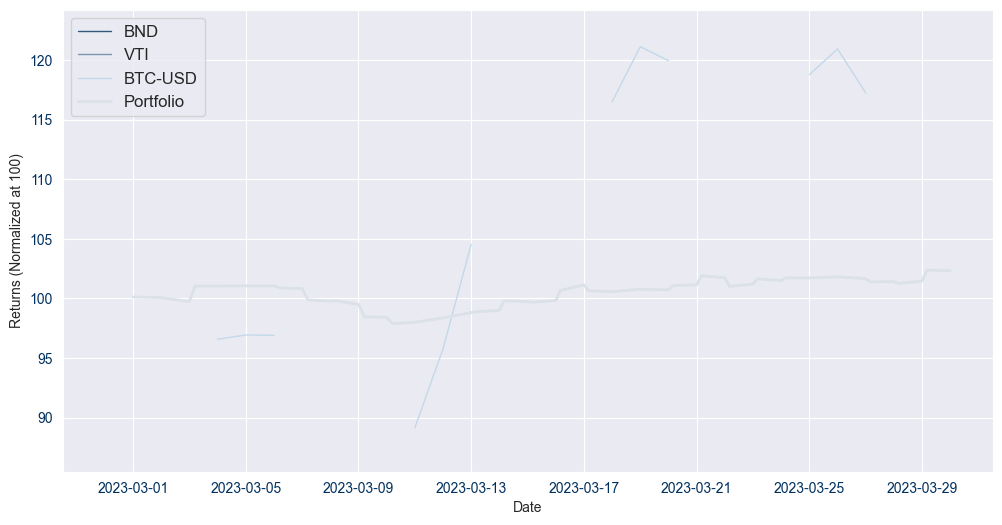

KeyError: 'BND'

<Figure size 1200x600 with 0 Axes>

In [105]:
rebalancing_frequency = 'M'
bitcoin_allocation = 0.05
bitcoin_rebalancing_frequency = 'Y'
start_date = None
end_date = None
run_portfolio(start_date, end_date, rebalancing_frequency, bitcoin_allocation, bitcoin_rebalancing_frequency)